### Import and configure modules

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [0]:
!pip install tensorflow-gpu==2.0.0-beta0;
import tensorflow as tf;

     |████████████████████████████████| 348.9MB 69kB/s 
     |████████████████████████████████| 61kB 17.2MB/s 
     |████████████████████████████████| 3.1MB 28.8MB/s 
     |████████████████████████████████| 501kB 36.7MB/s 


In [0]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

from PIL import Image

import numpy as np
import time
import functools
import skimage

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'ml/style_transfer/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


Download images and choose a style image and a content image:

In [0]:
content_path = base_dir + 'images/barn_mountains.jpg'
style_path = base_dir + 'images/watercolor.jpg'

## Visualize the input

Define a function to load an image and limit its maximum dimension to 512 pixels.

In [0]:
def load_img(path_to_img):
#   max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

#   shape = tf.cast(tf.shape(img)[:-1], tf.float32)
#   long_dim = max(shape)
#   scale = max_dim / long_dim

#   new_shape = tf.cast(shape * scale, tf.int32)

#   img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img


def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)
    

def load_img_yiq(path_to_img):
  full_img = Image.open(path_to_img)
  full_img = skimage.color.rgb2yiq(full_img)

  img =  full_img[:,:,0]
  img = img.reshape(img.shape[0], img.shape[1], 1)
  img = np.repeat(img, 3, axis=2)
  img = tf.constant(img, dtype=tf.float32)
  img = img[tf.newaxis, :]
  
  return full_img, img

Create a simple function to display an image:

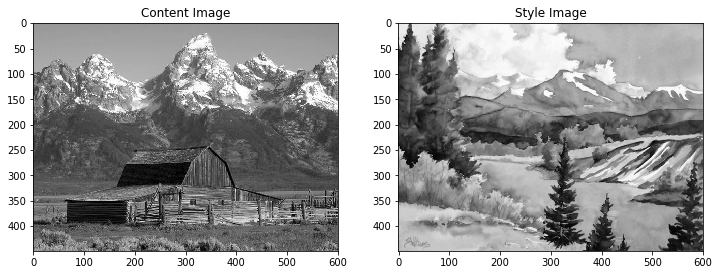

In [49]:
# content_image = load_img(content_path)
# style_image = load_img(style_path)

full_content_image, content_image = load_img_yiq(content_path)
full_style_image, style_image = load_img_yiq(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

In [0]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

# Content layer where will pull our feature maps
content_layers = ['block5_conv2'] 

# Style layer we are interested in
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # Load our model. We load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  
  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model


style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)


def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)


class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg =  vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}
    
    return {'content':content_dict, 'style':style_dict}
  

extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

style_results = results['style']

style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

image = tf.Variable(content_image)

def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

style_weight=1e-1
content_weight=1e4

def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss
  
def high_pass_x_y(image):
  x_var = image[:,:,1:,:] - image[:,:,:-1,:]
  y_var = image[:,1:,:,:] - image[:,:-1,:,:]

  return x_var, y_var

def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_mean(x_deltas**2) + tf.reduce_mean(y_deltas**2)

total_variation_weight=1e8

@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*total_variation_loss(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))
  return loss

image = tf.Variable(content_image)

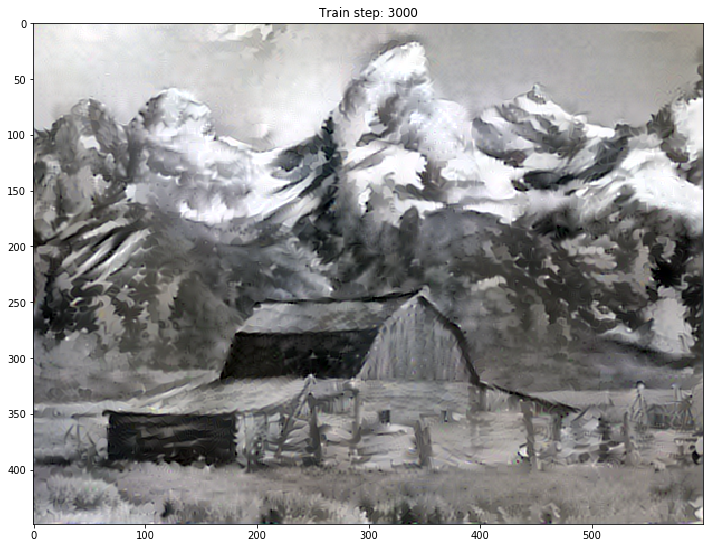

Total time: 776.0


In [51]:
import time
start = time.time()

epochs = 30
steps_per_epoch = 100

step = 0
loss_arr = []
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    loss = train_step(image)
    if (step % steps_per_epoch == 0):
      loss_arr.append(loss)
    print(".", end='')
  display.clear_output(wait=True)
  imshow(image.read_value())
  plt.title("Train step: {}".format(step))
  plt.show()

end = time.time()
print("Total time: {:.1f}".format(end-start))

In [0]:
def merge_channels(img, img_luminosity):
  img = np.copy(img)
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      img[i,j,0] = img_luminosity[0][i,j,0]
  return skimage.color.yiq2rgb(img)

W0613 11:01:01.531175 140379724171136 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


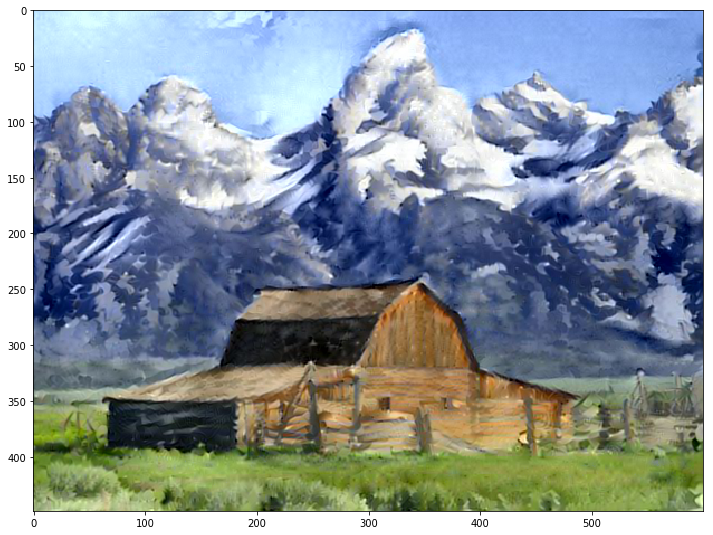

In [52]:
generated_style = image.read_value().numpy()
generated_image = merge_channels(full_content_image, generated_style)

plt.imshow(generated_image)

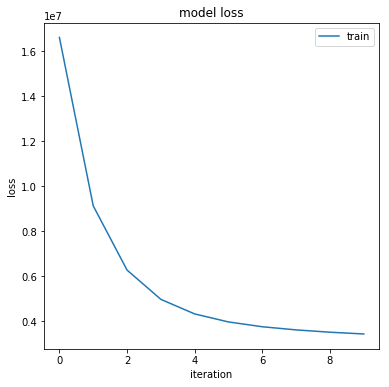

In [0]:
fig = plt.figure(figsize=(6,6))
plt.plot(loss_arr)
plt.title('model loss')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.legend(['train'], loc='upper right')
plt.show()

Finally, save the result:

In [55]:
from PIL import Image

import matplotlib
file_name = base_dir + 'generated/barn_mountains_colorpreserving.png'
# matplotlib.image.imsave(file_name, image[0])
matplotlib.image.imsave(file_name, generated_image)

W0613 11:04:39.117712 140379724171136 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
